# 03: ML Regression - QoE Prediction

This notebook builds regression models to predict QoE scores and tunes them using Optuna.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from src.telecom_qoe_analytics.data_loader import get_merged_dataset, get_time_split, setup_plotting, get_numeric_features, get_categorical_features

setup_plotting(context="paper", palette="deep", style="ticks")
df = get_merged_dataset()

📈 Plotting environment set: style=ticks, palette=deep, context=paper


## 1. Feature Engineering & Preprocessing

In [7]:
# Encode categorical variables
cat_cols = get_categorical_features(df)
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split data temporally
train_df, val_df, test_df = get_time_split(df)

X_train = train_df.drop(columns=["qoe_score", "session_id", "user_id", "cell_id", "timestamp_start"])
y_train = train_df["qoe_score"]
X_val = val_df.drop(columns=["qoe_score", "session_id", "user_id", "cell_id", "timestamp_start"])
y_val = val_df["qoe_score"]
X_test = test_df.drop(columns=["qoe_score", "session_id", "user_id", "cell_id", "timestamp_start"])
y_test = test_df["qoe_score"]

print("Encoding and time aware split done")

Encoding and time aware split done


## 2. Hyperparameter Tuning with Optuna

In [3]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    return mean_absolute_error(y_val, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print("Best parameters:", study.best_params)

[I 2025-12-31 21:44:22,837] A new study created in memory with name: no-name-fb2e6155-f57c-4c65-a56c-2165cc2d9a34
[I 2025-12-31 21:44:25,093] Trial 0 finished with value: 0.010031100585788528 and parameters: {'n_estimators': 193, 'max_depth': 7, 'learning_rate': 0.1538344699070786, 'subsample': 0.7205877710384156, 'colsample_bytree': 0.5798384988367233}. Best is trial 0 with value: 0.010031100585788528.
[I 2025-12-31 21:44:26,305] Trial 1 finished with value: 0.01540249181863722 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.2754005370359979, 'subsample': 0.7839070777088355, 'colsample_bytree': 0.7260201653024707}. Best is trial 0 with value: 0.010031100585788528.
[I 2025-12-31 21:44:29,980] Trial 2 finished with value: 0.011018323619921765 and parameters: {'n_estimators': 234, 'max_depth': 9, 'learning_rate': 0.26290391498288557, 'subsample': 0.9608595899716461, 'colsample_bytree': 0.6392107863635477}. Best is trial 0 with value: 0.010031100585788528.
[I 2025

Best parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.14977236737616126, 'subsample': 0.8361669345492788, 'colsample_bytree': 0.7078429920023046}


### 💡 How to read this: Hyperparameter Tuning
* **The Process:** The model "tries" different combinations of settings (depth, learning rate, etc.) to see which ones minimize error.
* **Best parameters:** These are the "hidden settings" that make the model perform best on YOUR data. No one-size-fits-all!


## 3. Final Model Evaluation

In [4]:
best_model = XGBRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

test_preds = best_model.predict(X_test)
print(f"Test MAE: {mean_absolute_error(y_test, test_preds):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

Test MAE: 0.0097
Test RMSE: 0.0127
Test R2: 0.9997


### 💡 How to read this: Regression Metrics
* **MAE (Mean Absolute Error):** Average error in "QoE points." If your MAE is 0.2, your model is off by 0.2 points on average (out of a 5.0 scale). This is very intuitive!
* **RMSE:** Like MAE but penalizes large errors more. If RMSE >> MAE, you have some data points where the model is failing badly.
* **R2 Score:** Accuracy for regression. 1.0 is perfect. 0.0 is as bad as guessing the average. >0.7 is usually excellent in telecom.


## 4. Feature Importance

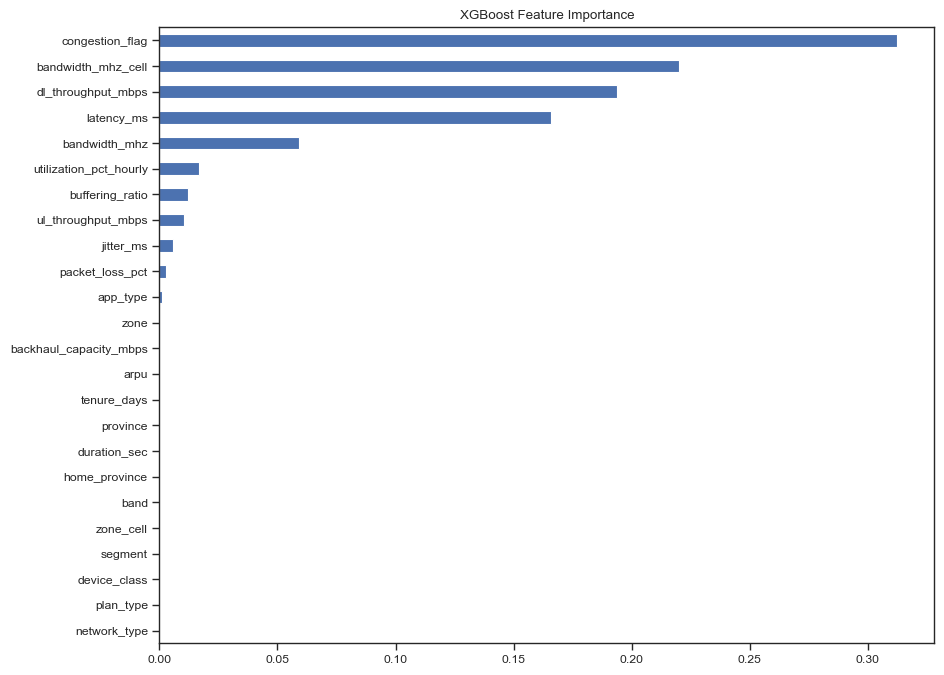

In [5]:
importance = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 8))
importance.plot(kind="barh")
plt.title("XGBoost Feature Importance")
plt.show()

### 💡 How to read this: Feature Importance
* **Top Bars:** These are the inputs that "learned" the most about QoE. 
* **The "So What":** If `latency_ms` is at the top, it proves that for this network, speed (bandwidth) matters less than responsiveness (latency) for customer happiness.
